# XGBoost

In [1]:
from Functions import get_result, plot_precision_recall_vs_threshold, plot_roc_curve, save_metrics_to_json
from sklearn.metrics import confusion_matrix, make_scorer, recall_score, precision_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Load the datasets for training (remember they are scaled)

In [2]:
filenames = ['X_train.pkl', 'Y_train.pkl', 'X_val.pkl', 'Y_val.pkl', 'X_test.pkl', 'Y_test.pkl']
data_folder = '../data/'
dataframes = [pd.read_pickle(data_folder + filename) for filename in filenames]
X_train, Y_train, X_val, Y_val, X_test, Y_test = dataframes

In [3]:
# The scores we want to look at
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0)
}

#### Hyperparameter Tuning

In [48]:
# We'll need the count of each class for a hyperparameter
risk_count = Y_train.value_counts()

In [49]:
param_grid = {
    'n_estimators': [100, 250, 500, 1000],          # Number of trees
    'max_depth': [5, 10, 25, 75],                   # Maximum depth of a tree
    'learning_rate': [0.1, 0.5, 1, 2.5],            # Step size shrinkage used in update to prevent overfitting
    'objective': ['binary:logistic'],               # The learning task and the corresponding learning objective
    'eval_metric': ['aucpr'],                       # Evaluation metrics for validation data
    'scale_pos_weight': [1, 100, 250, 500, 1000,    # Control the balance of positive and negative weights
                         risk_count[0]/risk_count[1]] # Typical value to consider
}

In [50]:
# Initialize the RandomForestClassifier
xgb = XGBClassifier()

# Initialize RandomizedSearchCV
xgb_random = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid, 
                               n_iter=50, cv=3, verbose=1, random_state=42, n_jobs=-1,
                               scoring=scoring, refit='f1')


In [52]:
xgb_random.fit(X_train, Y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/home/ykh/miniconda3/envs/tfgpu/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'scale_pos_weight': [1, 100, 250, 500,
                                                             1000,
                                                             709.7916666666666]},
                   random_state=42, refit='f1',
                   scoring={'accuracy': 'accuracy',
                            'f1': make_scorer(f1_score, response_method='predict', zero_division=0),
                            'precision': make_scorer(precision_score, response_method='predict', zero_division=0),
                            'recall': make_scorer(recall_score, response_method='predict', zero_division=0)},
                   verbose=1)

In [53]:
# Look at the results of the hyperparameter tuning
xgb_random_result_df = pd.DataFrame(xgb_random.cv_results_['params'])
xgb_random_result_df['Mean_Accuracy'] = xgb_random.cv_results_['mean_test_accuracy']
xgb_random_result_df['Mean_Recall'] = xgb_random.cv_results_['mean_test_recall']
xgb_random_result_df['Mean_Precision'] = xgb_random.cv_results_['mean_test_precision']
xgb_random_result_df['Mean_f1'] = xgb_random.cv_results_['mean_test_f1']
xgb_random_result_df['Rank_Recall'] = xgb_random.cv_results_['rank_test_recall']
xgb_random_result_df['Rank_Precision'] = xgb_random.cv_results_['rank_test_precision']
xgb_random_result_df['Rank_F1'] = xgb_random.cv_results_['rank_test_f1']
xgb_random_result_df.sort_values('Rank_F1')

,scale_pos_weight,objective,n_estimators,max_depth,learning_rate,eval_metric,Mean_Accuracy,Mean_Recall,Mean_Precision,Mean_f1,Rank_Recall,Rank_Precision,Rank_F1
9,1000.000000,binary:logistic,1000,10,1.0,aucpr,0.997212,0.390625,0.222295,0.283173,9,7,1
46,100.000000,binary:logistic,250,10,0.1,aucpr,0.997168,0.393229,0.219432,0.281546,6,10,2
11,1000.000000,binary:logistic,1000,5,0.5,aucpr,0.997161,0.393229,0.218891,0.281054,6,13,3
42,250.000000,binary:logistic,1000,5,0.5,aucpr,0.997179,0.390625,0.219263,0.280726,9,11,4
14,250.000000,binary:logistic,500,5,0.5,aucpr,0.997161,0.393229,0.218448,0.280701,6,15,5
37,1000.000000,binary:logistic,1000,10,0.1,aucpr,0.997194,0.388021,0.219852,0.280505,13,9,6
44,100.000000,binary:logistic,1000,10,0.5,aucpr,0.997212,0.385417,0.220563,0.280423,15,8,7
34,709.791667,binary:logistic,500,10,0.5,aucpr,0.997194,0.385417,0.219114,0.279249,15,12,8
21,500.000000,binary:logistic,500,10,0.1,aucpr,0.997194,0.385417,0.218852,0.279047,15,14,9
6,500.000000,binary:logistic,250,10,0.1,aucpr,0.997146,0.390625,0.216680,0.278567,9,16,10


In [ ]:
# Evaluate the Best Model
print(f"Best Parameters: {xgb_random.best_params_}")
#best_xgb_params = xgb_random.best_estimator_
best_xgb_params = xgb_random.best_params_

Best Parameters: {'scale_pos_weight': 1000, 'objective': 'binary:logistic', 'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 1, 'eval_metric': 'aucpr'}


In [39]:
best_xgb = XGBClassifier(**best_xgb_params)
best_xgb.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [40]:
# Save the best model
best_xgb.save_model('Saved models/xgb_best_model.json')

In [41]:
# Predict on the test set
test_predictions = best_xgb.predict(X_test)

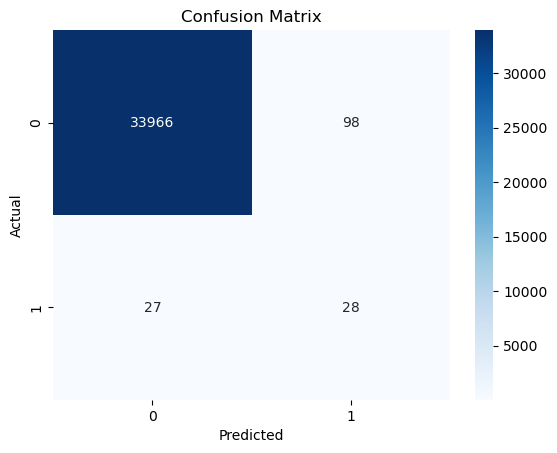

Recall       = 0.51
Precision    = 0.22
F1           = 0.31


In [ ]:
recall_1, precision_1, f1_1 = get_result(Y_test, test_predictions)

Lets merge the training and validation set and predict on the test set to see if the model can perform better with more training data.



In [43]:
# Initialize the RandomForestClassifier with the best hyperparameters from the tuning phase
xgb = XGBClassifier(**best_xgb_params)

In [ ]:
# Train the model
xgb.fit(pd.concat([X_train, X_val]), pd.concat([Y_train, Y_val]))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [45]:
test_predictions = xgb.predict(X_test)

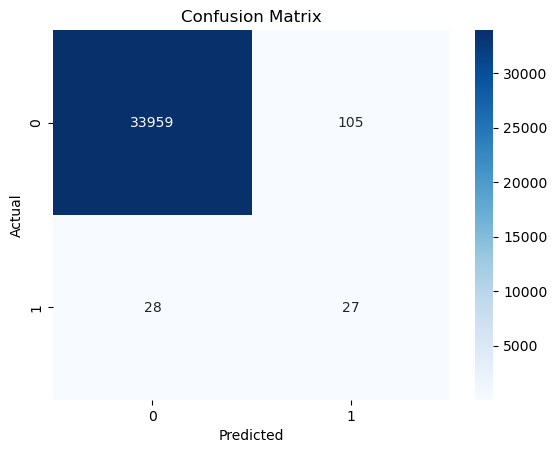

Recall       = 0.49
Precision    = 0.2
F1           = 0.29


In [ ]:
recall_2, precision_2, f1_2 = get_result(Y_test, test_predictions)

In [ ]:
if f1_2 > f1_1:
    xgb.save_model('Saved models/xgb_best_model.json') # Overwrite the previous best model
    save_metrics_to_json('XGBoost', recall_2, precision_2, f1_2)
    print('By training our model on more data, we achived a higher performance')
else:
    save_metrics_to_json('XGBoost', recall_1, precision_1, f1_1)
    print('The first model we found, through hyperparameter tuning, is still our best model.')
    print('It had the following scores:')
    print('Recall       =', round(recall_1, 2))
    print('Precision    =', round(precision_1, 2))
    print('F1           =', round(f1_1, 2))

The first model we found, through hyperparameter tuning, is still our best model.
It had the following scores:
Recall       = 0.51
Precision    = 0.22
F1           = 0.31
